In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import sys
import random
import warnings
import pandas as pd
import pickle
from tqdm import tqdm_notebook, tqdm
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
import seaborn as sns
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
import time
from imageio import imread
import imageio
import shutil

import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras import optimizers
from keras.models import Model, load_model
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import pickle
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Input, Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from keras.models import Model, Sequential
from keras.layers import ZeroPadding2D
from keras.regularizers import l2

from keras.applications.resnet50 import ResNet50

import keras



Using TensorFlow backend.


In [0]:
path = '/content/drive/My Drive/Forensic_research/phase-01-training/dataset-dist/phase-01/training/'
path_drive = '/content/drive/My Drive/Forensic/AlexNet/'

# Getting Pristine and Forged images from the Folder

In [0]:
fake_path = path+'fake/'
pristine_path = path+'pristine/'

In [0]:
fakes = os.listdir(fake_path)
pristines = os.listdir(pristine_path)

In [0]:
pristines_final=[]
for pristine in pristines:
#     img=imread(pristine_path+pristine)
#     if len(img.shape)<3:
#         continue
#     if img.shape[2]==4:
#         continue
    pristines_final.append(pristine_path+pristine)

In [0]:
len(pristines_final)

1050

In [0]:
pristines_final[:4]

['/content/drive/My Drive/Forensic_research/phase-01-training/dataset-dist/phase-01/training/pristine/1de0e29092a4609337372ef968046d88.png',
 '/content/drive/My Drive/Forensic_research/phase-01-training/dataset-dist/phase-01/training/pristine/1ae50d32e718687e82c0b8fa0607c402.png',
 '/content/drive/My Drive/Forensic_research/phase-01-training/dataset-dist/phase-01/training/pristine/1b4bc069995090e56ff0722033b86c9a.png',
 '/content/drive/My Drive/Forensic_research/phase-01-training/dataset-dist/phase-01/training/pristine/00e079b66d9e9f99892bbb81d9d6cd57.png']

In [0]:
# fake_images=[]
fakes_final=[]
for fake in fakes:
#     print(fake)
#     img=imread(fake_path+fake)
    try:
#         fake_images.append(img[:,:,:3])
        fakes_final.append(fake_path+fake)
    except IndexError:
        print(f'image {fake} has only 1 channel')

In [0]:
image_names=[]
for i in range(0, len(pristines_final)):
    image_names.append(pristines_final[i])
for i in range(0, len(fakes_final)):
    image_names.append(fakes_final[i])

In [0]:
len(image_names)

1501

In [0]:
image_names.index('/content/drive/My Drive/Forensic_research/phase-01-training/dataset-dist/phase-01/training/fake/.DS_Store')

1050

In [0]:
del image_names[1050]

In [0]:
len(image_names)

1500

## I have given pristine image as 1 and forged image as 0 to for classification of images

In [0]:
labels=[1]*1050+[0]*450

## Creating train and Test image data from datset

In [0]:
x, x_test, y, y_test = train_test_split(image_names, labels, test_size=0.2, stratify=labels)
x_train, x_cv, y_train, y_cv = train_test_split(x, y, test_size=0.2, stratify=y)

In [0]:
x_train_images = []
for image in x_train:
    try:
#         image_path = pristine_path+x
        # load an image from file
        image = load_img(image, target_size=(227, 227))
#     except FileNotFoundError:
#         image_path = fake_path+x
#         # load an image from file
#         image = load_img(image, target_size=(224, 224))
    except Exception as e:
        print(str(e))
        print(x)
    
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    x_train_images.append(image)

In [0]:
len(x_train_images)

960

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


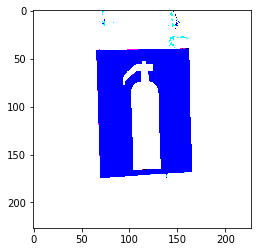

In [0]:
plt.imshow(x_train_images[386][0])

In [0]:
x_train_images[381].shape

(1, 227, 227, 3)

In [0]:
x_test_images = []
for image in x_test:
    try:
#         image_path = pristine_path+x
        # load an image from file
        image = load_img(image, target_size=(227, 227))
#     except FileNotFoundError:
#         image_path = fake_path+x
#         # load an image from file
#         image = load_img(image_path, target_size=(224, 224))
    except Exception as e:
        print(str(e))
        print(x)
    
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    
#     print(image)
#     plt.imshow(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    x_test_images.append(image)
#     break

In [0]:
x_cv_images = []
for image in x_cv:
    try:
#         image_path = pristine_path+x
        # load an image from file
        image = load_img(image, target_size=(227, 227))
#     except FileNotFoundError:
#         image_path = fake_path+x
#         # load an image from file
#         image = load_img(image_path, target_size=(224, 224))
    except Exception as e:
        print(str(e))
        print(x)
    
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    
#     print(image)
#     plt.imshow(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    x_cv_images.append(image)

In [0]:
x_train_images = np.array(x_train_images)
x_cv_images = np.array(x_cv_images)
x_test_images = np.array(x_test_images)
y_train = np.array(y_train)
y_cv = np.array(y_cv)
y_test = np.array(y_test)

In [0]:
print(x_train_images.shape)
print(x_cv_images.shape)
print(x_test_images.shape)
x_train_images = np.rollaxis(x_train_images,1,0)
x_cv_images = np.rollaxis(x_cv_images,1,0)
x_test_images = np.rollaxis(x_test_images,1,0)
print(x_train_images.shape)
print(x_cv_images.shape)
print(x_test_images.shape)

(960, 1, 227, 227, 3)
(240, 1, 227, 227, 3)
(300, 1, 227, 227, 3)
(1, 960, 227, 227, 3)
(1, 240, 227, 227, 3)
(1, 300, 227, 227, 3)


In [0]:
x_train_images = x_train_images[0]
x_cv_images = x_cv_images[0]
x_test_images = x_test_images[0]
print(x_train_images.shape)
print(x_cv_images.shape)
print(x_test_images.shape)

In [0]:
import pickle
pickle_in = open(path_drive+"x_train_images.pickle","rb")
x_train_images = pickle.load(pickle_in)

pickle_in = open(path_drive+"x_cv_images.pickle","rb")
x_cv_images = pickle.load(pickle_in)

pickle_in = open(path_drive+"x_test_images.pickle","rb")
x_test_images = pickle.load(pickle_in)

pickle_in = open(path_drive+"y_train.pickle","rb")
y_train = pickle.load(pickle_in)

pickle_in = open(path_drive+"y_cv.pickle","rb")
y_cv = pickle.load(pickle_in)

pickle_in = open(path_drive+"y_test.pickle","rb")
y_test = pickle.load(pickle_in)

In [5]:
print(x_train_images.shape)
print(x_cv_images.shape)
print(x_test_images.shape)

(3572, 227, 227, 3)
(73, 227, 227, 3)
(75, 227, 227, 3)


## Doing Feature Scaling on Image data to make all the image pixel to same pixel

In [0]:
x_train_images/=255
x_cv_images/=255
x_test_images/=255

In [0]:
num_classes = 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


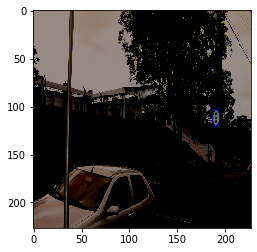

In [8]:
plt.imshow(x_test_images[3])

# **In the paper people used AlexNet Pretrained model but I was not getting pretrained features of AlexNet that is why I have used VGG16 as pretrained Model and trained AlexNet from scratch.**

# AlexNet Model

In [0]:
def alexnet_model(img_shape=(227, 227, 3), n_classes=1, l2_reg=0.,
	weights=None):

  # Initialize model
  alexnet = Sequential()

  # Layer 1
  alexnet.add(Conv2D(96, (11, 11), input_shape=img_shape, strides = (4,4)))
  alexnet.add(BatchNormalization())
  alexnet.add(Activation('relu'))
  alexnet.add(MaxPooling2D(pool_size=(3, 3), strides = (2, 2)))

  # Layer 2
  alexnet.add(ZeroPadding2D((2, 2)))
  alexnet.add(Conv2D(256, (5, 5)))
  alexnet.add(BatchNormalization())
  alexnet.add(Activation('relu'))
  alexnet.add(MaxPooling2D(pool_size=(3, 3),  strides = (2 , 2)))

  # Layer 3
  alexnet.add(ZeroPadding2D((1, 1)))
  alexnet.add(Conv2D(384, (3, 3)))
  alexnet.add(BatchNormalization())
  alexnet.add(Activation('relu'))
  # alexnet.add(MaxPooling2D(pool_size=(2, 2)))

  # Layer 4
  alexnet.add(ZeroPadding2D((1, 1)))
  alexnet.add(Conv2D(384, (3, 3)))
  # alexnet.add(BatchNormalization())
  alexnet.add(Activation('relu'))

  # Layer 5
  alexnet.add(ZeroPadding2D((1, 1)))
  alexnet.add(Conv2D(256, (3, 3)))
  # alexnet.add(BatchNormalization())
  alexnet.add(Activation('relu'))
  alexnet.add(MaxPooling2D(pool_size=(3, 3),  strides = (2, 2)))

  # Layer 6
  alexnet.add(Flatten())
  alexnet.add(Dense(4096))
  # alexnet.add(BatchNormalization())
  alexnet.add(Activation('relu'))
  alexnet.add(Dropout(0.5))

  # Layer 7
  alexnet.add(Dense(4096))
  # alexnet.add(BatchNormalization())
  alexnet.add(Activation('relu'))
  # alexnet.add(Dropout(0.5))
  alexnet.add(Dense(1000))
  # alexnet.add(BatchNormalization())
  alexnet.add(Activation('relu'))

  # Layer 8
  alexnet.add(Dense(n_classes))
  # alexnet.add(BatchNormalization())
  alexnet.add(Activation('softmax'))

  if weights is not None:
    alexnet.load_weights(weights)

  return alexnet

In [0]:
model = alexnet_model()

In [0]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_49 (Batc (None, 55, 55, 96)        384       
_________________________________________________________________
activation_71 (Activation)   (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
zero_padding2d_13 (ZeroPaddi (None, 31, 31, 96)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_50 (Batc (None, 27, 27, 256)      

In [0]:
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [0]:
t = time.time()
history = model.fit(x_train_images, y_train,
          batch_size=16,
          epochs=20,
          verbose=1,
          validation_data=(x_cv_images, y_cv))
print("Training Time: %s "%(time.time()-t))

Train on 3572 samples, validate on 73 samples
Epoch 1/20
3572/3572 [==============================] - 13s 4ms/step - loss: 10.5420 - acc: 0.3387 - val_loss: 11.1378 - val_acc: 0.3014
Epoch 2/20
3572/3572 [==============================] - 9s 3ms/step - loss: 10.5420 - acc: 0.3387 - val_loss: 11.1378 - val_acc: 0.3014
Epoch 3/20
3572/3572 [==============================] - 9s 3ms/step - loss: 10.5420 - acc: 0.3387 - val_loss: 11.1378 - val_acc: 0.3014
Epoch 4/20
3572/3572 [==============================] - 9s 3ms/step - loss: 10.5420 - acc: 0.3387 - val_loss: 11.1378 - val_acc: 0.3014
Epoch 5/20
3572/3572 [==============================] - 9s 3ms/step - loss: 10.5420 - acc: 0.3387 - val_loss: 11.1378 - val_acc: 0.3014
Epoch 6/20
3572/3572 [==============================] - 9s 3ms/step - loss: 10.5420 - acc: 0.3387 - val_loss: 11.1378 - val_acc: 0.3014
Epoch 7/20
3572/3572 [==============================] - 9s 3ms/step - loss: 10.5420 - acc: 0.3387 - val_loss: 11.1378 - val_acc: 0.3014
E

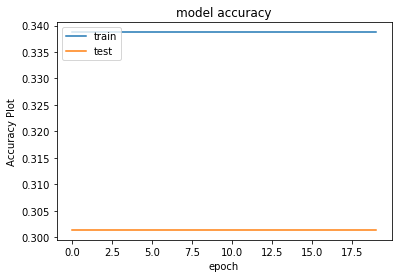

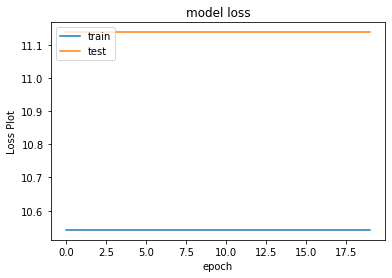

In [0]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
(loss, accuracy) = model.evaluate(x_test_images, y_test, verbose=0)

print("[INFO] loss={:.4f}, accuracy={:.4f}%".format(loss,accuracy*100))

[INFO] loss=9.9906, accuracy=37.3333%


# Applied KFOLD on AlexNet To increase Accuracy

In [0]:
def alexnet_model(optimizer):

  # Initialize model
  alexnet = Sequential()

  # Layer 1
  alexnet.add(Conv2D(96, (11, 11), input_shape=(227,227,3), strides = (4,4)))
  alexnet.add(BatchNormalization())
  alexnet.add(Activation('relu'))
  alexnet.add(MaxPooling2D(pool_size=(3, 3), strides = (2, 2)))

  # Layer 2
  alexnet.add(ZeroPadding2D((2, 2)))
  alexnet.add(Conv2D(256, (5, 5)))
  alexnet.add(BatchNormalization())
  alexnet.add(Activation('relu'))
  alexnet.add(MaxPooling2D(pool_size=(3, 3),  strides = (2 , 2)))

  # Layer 3
  alexnet.add(ZeroPadding2D((1, 1)))
  alexnet.add(Conv2D(384, (3, 3)))
  alexnet.add(BatchNormalization())
  alexnet.add(Activation('relu'))
  # alexnet.add(MaxPooling2D(pool_size=(2, 2)))

  # Layer 4
  alexnet.add(ZeroPadding2D((1, 1)))
  alexnet.add(Conv2D(384, (3, 3)))
  # alexnet.add(BatchNormalization())
  alexnet.add(Activation('relu'))

  # Layer 5
  alexnet.add(ZeroPadding2D((1, 1)))
  alexnet.add(Conv2D(256, (3, 3)))
  # alexnet.add(BatchNormalization())
  alexnet.add(Activation('relu'))
  alexnet.add(MaxPooling2D(pool_size=(3, 3),  strides = (2, 2)))

  # Layer 6
  alexnet.add(Flatten())
  alexnet.add(Dense(4096))
  # alexnet.add(BatchNormalization())
  alexnet.add(Activation('relu'))
  alexnet.add(Dropout(0.5))

  # Layer 7
  alexnet.add(Dense(4096))
  # alexnet.add(BatchNormalization())
  alexnet.add(Activation('relu'))
  # alexnet.add(Dropout(0.5))
  alexnet.add(Dense(1000))
  # alexnet.add(BatchNormalization())
  alexnet.add(Activation('relu'))

  # Layer 8
  alexnet.add(Dense(1))
  # alexnet.add(BatchNormalization())
  alexnet.add(Activation('softmax'))

  alexnet.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['acc'])

  # if weights is not None:
  #   alexnet.load_weights(weights)

  return alexnet

### Merging Train and Validation dataset to do KFold cross validation training

In [0]:
train_images = np.vstack((x_train_images,x_cv_images))

In [16]:
train_images.shape

(3645, 227, 227, 3)

In [0]:
y = np.concatenate([y_train,y_cv])

In [15]:
y.shape

(3645,)

In [0]:
classifier = KerasClassifier(build_fn = alexnet_model, batch_size = 10, epochs = 100)
parameter = {'batch_size':[25,32],
             'nb_epoch': [100,500],
             'optimizer':['adam', 'rmsprop', 'sgd']}

grid_search = GridSearchCV(estimator = classifier, param_grid = parameter, scoring = 'accuracy', cv = 10)
grid_search = grid_search.fit(train_images, y)

best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

Epoch 1/100
3280/3280 [==============================] - 10s 3ms/step - loss: 10.5181 - acc: 0.3402
Epoch 2/100
3280/3280 [==============================] - 7s 2ms/step - loss: 10.5181 - acc: 0.3402
Epoch 3/100
3280/3280 [==============================] - 7s 2ms/step - loss: 10.5181 - acc: 0.3402
Epoch 4/100
3280/3280 [==============================] - 7s 2ms/step - loss: 10.5181 - acc: 0.3402
Epoch 5/100
3280/3280 [==============================] - 7s 2ms/step - loss: 10.5181 - acc: 0.3402
Epoch 6/100
3280/3280 [==============================] - 7s 2ms/step - loss: 10.5181 - acc: 0.3402
Epoch 7/100
3280/3280 [==============================] - 7s 2ms/step - loss: 10.5181 - acc: 0.3402
Epoch 8/100
3280/3280 [==============================] - 7s 2ms/step - loss: 10.5181 - acc: 0.3402
Epoch 9/100
3280/3280 [==============================] - 7s 2ms/step - loss: 10.5181 - acc: 0.3402
Epoch 10/100
3280/3280 [==============================] - 7s 2ms/step - loss: 10.5181 - acc: 0.3402
Epoch 11

## From the Result we can see that we are getting only 34.62% accuracy on AlexNet Model, Not I am trying to train dataset on VGG16 pretrained model to see what accuracy we can get.

# Using Pretrained VGG16 Model

In [34]:
vgg_model=VGG16(weights='imagenet', include_top=False, input_shape=(227,227,3))

model_aug=Sequential()
model_aug.add(vgg_model)


model = Sequential()
model.add(Conv2D(1024, kernel_size=(2, 2),
                 activation='relu',
                 input_shape=(7,7,512)))

model.add(Conv2D(512, (2, 2),
                 activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# model.add(Dropout(0.4))

model.add(Conv2D(512, (2, 2),
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
# model.add(Dropout(0.6))
model.add(Dense(4096, activation='relu'))
# model.add(Dropout(0.6))
model.add(Dense(1024, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))


model_aug.add(model)

model_aug.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 34619393  
Total params: 49,334,081
Trainable params: 49,332,033
Non-trainable params: 2,048
_________________________________________________________________


In [0]:
for layer in model_aug.layers[0].layers[:17]:
    layer.trainable=False
# print(len(model_aug.layers[0].layers))

In [36]:
model_aug.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=1e-4), metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [37]:
t = time.time()
history = model_aug.fit(x_train_images, y_train,
          batch_size=64,
          epochs=12,
          verbose=1,
          validation_data=(x_cv_images, y_cv))
print("Training Time: %s "%(t - time.time()))



Train on 3572 samples, validate on 73 samples
Epoch 1/12
3572/3572 [==============================] - 16s 4ms/step - loss: 0.4820 - acc: 0.8038 - val_loss: 0.3831 - val_acc: 0.8493
Epoch 2/12
3572/3572 [==============================] - 11s 3ms/step - loss: 0.2981 - acc: 0.8922 - val_loss: 0.4833 - val_acc: 0.8219
Epoch 3/12
3572/3572 [==============================] - 11s 3ms/step - loss: 0.2024 - acc: 0.9404 - val_loss: 0.4581 - val_acc: 0.8219
Epoch 4/12
3572/3572 [==============================] - 11s 3ms/step - loss: 0.1422 - acc: 0.9636 - val_loss: 0.5562 - val_acc: 0.8493
Epoch 5/12
3572/3572 [==============================] - 11s 3ms/step - loss: 0.1167 - acc: 0.9686 - val_loss: 0.5142 - val_acc: 0.8219
Epoch 6/12
3572/3572 [==============================] - 11s 3ms/step - loss: 0.1039 - acc: 0.9689 - val_loss: 0.7112 - val_acc: 0.8219
Epoch 7/12
3572/3572 [==============================] - 11s 3ms/step - loss: 0.0945 - acc: 0.9698 - val_loss: 0.9894 - val_acc: 0.8219
Epoch 8

## From the accuracy curve we can see that VGG16 is giving very good accuracy on Dataset as compare to AlexNet

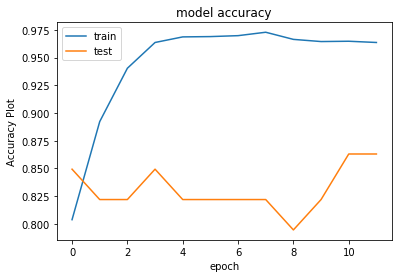

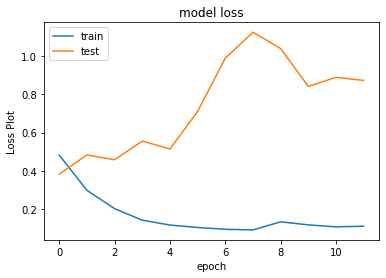

In [38]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss Plot')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
(loss, accuracy) = model_aug.evaluate(x_test_images, y_test, verbose=0)
print("[INFO] loss={:.4f}, accuracy={:.4f}%".format(loss,accuracy*100))

[INFO] loss=0.8146, accuracy=88.0000%


In [0]:
def prediction_value(n_cases):
  value = model_aug.predict(x_test_images[n_cases].reshape(1,227,227,3))
  plt.imshow(x_test_images[n_cases])
  if value < 0.5:
    print("Predicted Image is forged")
  else:
    print("Predicted Image is pristine")

  if y_test[n_cases] < 0.5:
    print("Actual Image is forged")
  else:
    print("Actual Image is pristine")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Image is pristine
Actual Image is pristine


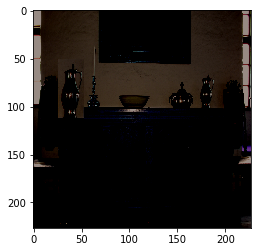

In [45]:
prediction_value(55)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Image is forged
Actual Image is forged


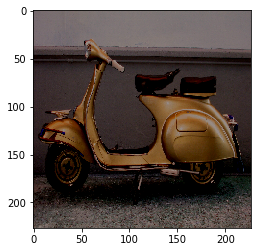

In [44]:
prediction_value(5)

# Applied SVM Classifier on VGG16 Pretrained Model

I have used Vgg16 as pretrained because I am not getting good accuracy on AlexNet Model

In [0]:
def vgg_model():
  vgg_model=VGG16(weights='imagenet', include_top=False, input_shape=(227,227,3))

  # model_aug.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  # model_aug.summary()

  return vgg_model

In [11]:
model_vgg = vgg_model()
model_vgg.summary()





58892288/58889256 [==============================] - 5s 0us/step






Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 227, 227, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 227, 227, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 227, 227, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 113, 113, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 113, 113, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 113, 113, 128)     147584    
____________________________________________________

In [0]:
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()
batch_size = 32

def extract_features(sample_count,train, y):
    features = np.zeros(shape=(sample_count, 7, 7, 512))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    i = 0
    for x_batch, y_batch in datagen.flow(train, y, batch_size=batch_size):
        # model.fit(x_batch, y_batch)
        # batches += 1
        # if batches >= len(x_train) / 32:
    # generator = datagen.flow_from_directory(directory,
    #                                         target_size=(img_width,img_height),
    #                                         batch_size = batch_size,
    #                                         class_mode='binary')
    # Pass data through convolutional base
    # for inputs_batch, labels_batch in generator:
          features_batch = model_vgg.predict(x_batch)
          features[i * batch_size: (i + 1) * batch_size] = features_batch
          labels[i * batch_size: (i + 1) * batch_size] = y_batch
          i += 1
          if i * batch_size >= sample_count:
              break
    return features, labels

In [0]:
sample_count = train_images.shape[0]
train_features, train_labels = extract_features(sample_count, train_images, y)  # Agree with our small dataset size
test_features, test_labels = extract_features(x_test_images.shape[0],x_test_images, y_test)

In [18]:
train_features.shape

(3645, 7, 7, 512)

In [19]:
train_labels.shape

(3645,)

In [40]:
from sklearn.svm import LinearSVC
X_train = train_features.reshape(train_features.shape[0],7*7*512)
param = [{
          "C": [0.01, 0.1, 1, 10, 100],
          "penalty":["l2"]
         }]
 
svm = LinearSVC(loss='squared_hinge')  # As in Tang (2013)
grid_search = GridSearchCV(svm, param, cv=10)
grid_search = grid_search.fit(X_train, train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
import pickle
pickle_out = open(path_drive+ "sv_model.pickle","wb")
pickle.dump(grid_search, pickle_out)
pickle_out.close()

In [45]:
print('Best score for data1:', grid_search.best_score_) 

Best score for data1: 0.8186556927297668


In [47]:
print('Best Kernel:',grid_search.best_estimator_)
# print('Best Gamma:',grid_search.best_estimator_)

Best Kernel: LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


In [0]:
import pickle
pickle_in = open(path_drive+"sv_model.pickle","rb")
grid_search = pickle.load(pickle_in)

In [0]:
def visualize_predictions(classifier, n_cases):
  features = model_vgg.predict(x_test_images[n_cases].reshape(1,227, 227, 3))

  # Make prediction
  try:
      prediction = classifier.predict(features)
  except:
      prediction = classifier.predict(features.reshape(1, 7*7*512))

  # Show picture
  plt.imshow(x_test_images[n_cases])
  plt.show()

  # Write prediction
  if prediction < 0.5:
      print('Predicted Image as Forged')
  else:
      print('Predicted Image as Prestine')

  if y_test[n_cases] < 0.5:
      print('Actual Image is Forged')
  else:
      print('Actual Image is Prestine')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


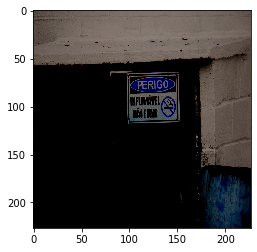

Predicted Image as Forged
Actual Image is Forged


In [29]:
visualize_predictions(grid_search, 6)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


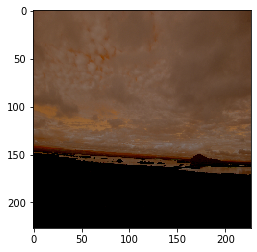

Predicted Image as Forged
Actual Image is Forged


In [30]:
visualize_predictions(grid_search, 10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


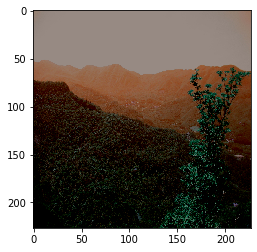

Predicted Image as Forged
Actual Image is Forged


In [31]:
visualize_predictions(grid_search, 16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


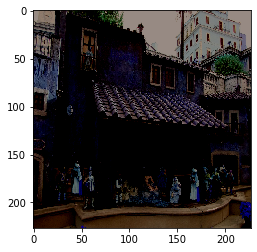

Predicted Image as Prestine
Actual Image is Prestine


In [33]:
visualize_predictions(grid_search, 66)

# In the paper it is mentioned that AlexNet with SVM Classifier gives good accuracy on test data but i am not getting good accuracy but VGG16 with SVM Classifier gives good accuracy but good as VGG16 with Dense layer(Softmax) classifer.

# **CONCLUSION :**

#### **Accuracy of Model with VGG16+ SVM Classifier 81.8%**
#### **Accuracy of model with VGG16 88%**
#### **Accuracy of model with AlexNet 34.62%**